In [12]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import sklearn.datasets
from scipy.stats import multivariate_normal
import pandas as pd
import seaborn

import sys
sys.version_info

sys.version_info(major=3, minor=12, micro=3, releaselevel='final', serial=0)

In [13]:
import matplotlib as mpl
mpl.rcParams['axes.grid'] = True  # Use per default a grid, i.e. plt.grid()

- `Tab`: Code completion or indent
- `Shift-Tab`: Tooltip
- `Shift-Tab Shift+Tab`: Long tooltip
- `Ctrl-Enter`: Run selected cells
- `Shift-Enter`: Run cell, select below
- `Alt-Enter`: Run cell and insert below
- `Ctrl-#`: Comment
- `Esc a`: New cell above
- `Esc b`: New cell below
- `Esc d d`: Delete current cell
- `Esc m`: Turn current cell into Markdown cell
- `Esc y`: Turn current cell into code cell

![1*f6KbPXwksAliMIsibFyGJw.png](https://miro.medium.com/max/700/1*f6KbPXwksAliMIsibFyGJw.png)

<!-- Source https://towardsdatascience.com/the-iris-dataset-a-little-bit-of-history-and-biology-fb4812f5a7b5 -->
 

| English | Description | German
|:--- |:--- |:---
|Iris | flowering plant genus | Schwertlilien
|Iris setosa | iris type | Borsten-Schwertlilie
|Iris versicolor | iris type | Verschiedenfarbige Schwertlilie
|Iris virginica | iris type | Virginische Schwertlilie
|Sepal | Leaf type | Kelchblatt
|Petal | Leaf type | Blütenblatt

# Understand the dataset

In [14]:
ds = sklearn.datasets.load_iris()
print(ds['DESCR'])

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

:Number of Instances: 150 (50 in each of three classes)
:Number of Attributes: 4 numeric, predictive attributes and the class
:Attribute Information:
    - sepal length in cm
    - sepal width in cm
    - petal length in cm
    - petal width in cm
    - class:
            - Iris-Setosa
            - Iris-Versicolour
            - Iris-Virginica

:Summary Statistics:

============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================

:Missing Attribute Values: None
:Class Distribution: 33.3% for each of 3 classes.
:Cr

In [15]:
ds.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names', 'filename', 'data_module'])

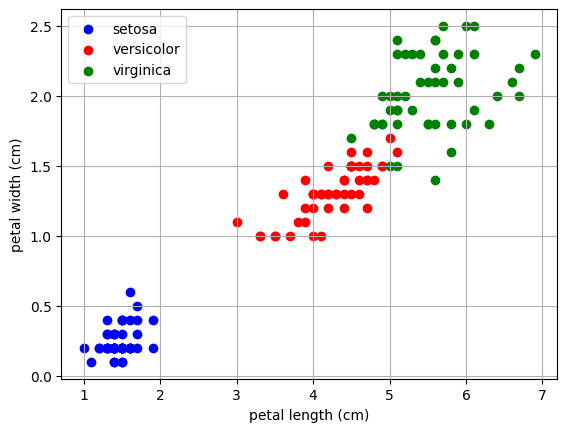

In [16]:
def add_scatter_to_plot(ds):
    colors = ['blue', 'red', 'green']
    for target_index, (target_name, color) in enumerate(zip(ds['target_names'], colors)):
        X = ds['data'][ds['target'] == target_index, :]
        plt.scatter(X[:, 2], X[:, 3], c=color, label=target_name)
    plt.legend()
    plt.xlabel(ds['feature_names'][2])
    plt.ylabel(ds['feature_names'][3])

add_scatter_to_plot(ds)
plt.show()

# a) Two-class Logistic Regression with Gradient Ascent

The posterior probabilities of a two class problem (here: "virginica" vs. "not virginica") shall be estimated using logistic regression.
- Start with the logistic regression loglikelihood function (script Eq. (2.43) and derive a gradient based iterative update scheme for the parameters $\mathbf w$ and $w_0$.

## 1) Define and plot the sigmoid function
The sigmoid function is defined as follows:
\begin{align}
\sigma(x) = \frac{1}{1+\mathrm e^{-x}} &= (1+\mathrm e^{-x})^{-1}
\end{align}

Text(0, 0.5, 'sigmoid(x)')

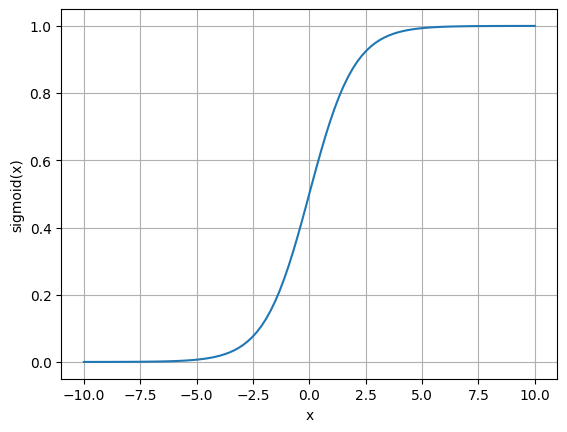

In [17]:
def sigmoid(x):
    return (1 + np.exp(-x))**(-1)

x = np.linspace(-10, 10, num=100)
plt.plot(x, sigmoid(x))
plt.xlabel('x')
plt.ylabel('sigmoid(x)')

## 2) Find the update equations for gradient ascent

The log-likelihood is defined as follows (see lecture):

\begin{align}
\ell( w_0, \mathbf w) &= \sum_{n=1}^N \bigg(
\tilde c_n \ln \, \sigma(\mathbf w^{\mathsf T}\mathbf x_n + w_0) + (1-\tilde c_n)\ln\,\big(1-\sigma(\mathbf w^{\mathsf T}\mathbf x_n + w_0)\big)
\bigg) \\
\tilde c_n &\in \{0, 1\}
\end{align}

where $\mathbf w = [w_1, w_2, ...]^{\mathsf T}$

To simplify the matter, lets first find a nice derivative for the sigmoid function.

**Find a form of the derivative of $\sigma(x)$ which just depends on $\sigma(x)$ and _not_ directly on $e^{()}$ or $\sigma(-x)$**
\begin{align}
\frac{\partial \sigma(x)}{\partial x}
&= \sigma(x)-\sigma(x)^2
\end{align}

**Find the derivatives of the cost function itself.**

\begin{align}
\frac{\partial\ell}{\partial w_0}
&= \sum_{n=1}^N 
\tilde c_n - \sigma(\mathbf w^{\mathsf T}\mathbf x_n + w_0)
\end{align}

\begin{align}
\frac{\partial\ell}{\partial w_d}
&= \sum_{n=1}^N \bigg(  % REPLACE &= \color{red}{???}
\tilde c_n \cdot \frac{1}{\sigma(\dots)} \cdot \sigma(\dots) \cdot \big(1-\sigma(\dots)\big) x_{d,n}  % REPLACE
+ (1 - \tilde c_n) \cdot \frac{1}{1-\sigma(\dots)} \cdot (-1) \sigma(\dots) \cdot \big(1-\sigma(\dots)\big) x_{d,n}  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N x_{d,n} \bigg(  % REPLACE
\tilde c_n \big(1-\sigma(\dots)\big)  % REPLACE
- (1 - \tilde c_n) \sigma(\dots)  % REPLACE
\bigg) \\  % REPLACE
&= \sum_{n=1}^N x_{d,n} \bigg(  % REPLACE
\tilde c_n - \sigma(\mathbf w^{\mathsf T} \mathbf x_n + w_0)  % REPLACE
\bigg)  % REPLACE
\end{align}

Based on these gradients a gradient ascent algorithm can be defined as follows:
\begin{align}
\mathbf w^{(\kappa + 1)}
&= \mathbf w^{(\kappa)} + \mu \left.\frac{\partial\ell}{\partial \mathbf w}\right|_{w_0^{(\kappa)}, \mathbf w^{(\kappa)}} &  % REPLACE &= \color{red}{???} &
w_0^{(\kappa + 1)}
&= w_0^{(\kappa)} + \mu \left.\frac{\partial\ell}{\partial \mathbf w}\right|_{w_0^{(\kappa)}, \mathbf w^{(\kappa)}}  % REPLACE &= \color{red}{???}
\end{align}

## 3) Implement the gradient ascent algorithm

**Define `features` to only use the petal length and width and `labels` for the two classes "virginica" and "not virginica"**

In [18]:
features = ds['data'][:, 2:]
features.shape

(150, 2)

In [19]:
labels = (ds['target'] == 2)
labels.shape

(150,)

**Note for implementing $\mathbf w^{\mathsf T}\mathbf x_n$**

We need to multiply the `features` and weight vector `w` along the feature dimension and then perform the summation. This is what corresponds to $\mathbf w^{\mathsf T}\mathbf x_n$ in math notation.

Possible ways:

- `np.sum(w[None, :] * features, axis=-1)`: Here, `None` introduces a singleton dimension in `w`. Then elementwise multiplication uses broadcasting.
- `features @ w`: Multiplies the last dimension of `features` with the first dimension of `w`.
- `einsum('nd,d->n', features, w)`: Here, since `d` appears more than once, multiplication and summation is performed along that axis. Check the [Einsum documentation](https://docs.scipy.org/doc/numpy-1.14.0/reference/generated/numpy.einsum.html).

All presented ways use low-level C or Fortran code to perform the loop iterations.
Decide for yourself, which one genereralizes well and stays readable.

**Implement the algorithm in the template below**

In [20]:
D = 2
w = np.zeros((D,))
w0 = np.zeros(())

# iterations: number of update steps
iterations = 1000
learning_rate = 0.1
for _ in range(iterations):
    grad_w0 = np.sum(labels - sigmoid(features @ w + w0), axis=0)  
    grad_w = np.sum(((labels - sigmoid(features @ w + w0)))[:, None] * features,axis=0)  
    
    assert grad_w0.shape == (), grad_w0.shape
    assert grad_w.shape == (D,), grad_w.shape
    
    # Gradient ascent, since we want to maximize the log-likelihood.
    w0 = w0 + learning_rate * grad_w0
    w = w + learning_rate * grad_w
    
    assert w.shape == (D,), w.shape
    assert w0.shape == (), w0.shape

w, w0

(array([18.39789085, 56.37826298]), -180.7631049593287)

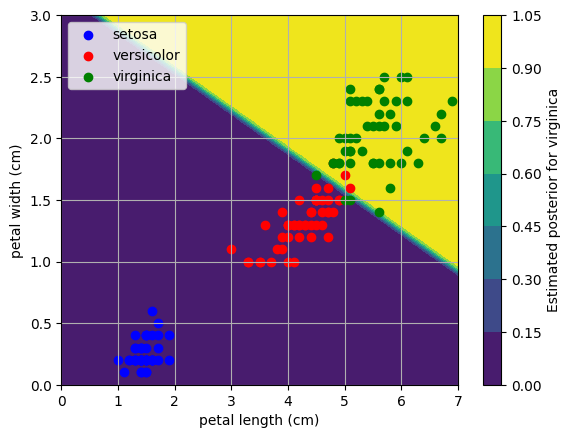

In [21]:
def compute_complete_grid(xlim, ylim, steps):
    x, y = np.meshgrid(
        np.linspace(*xlim, steps),
        np.linspace(*ylim, steps)
    )
    features_grid = np.moveaxis(np.array([x, y]), source=0, destination=-1)
    assert features_grid.shape == (steps, steps, 2), features_grid.shape
    return x, y, features_grid

steps = 100
x, y, features_grid = compute_complete_grid((0, 7), (0, 3), steps=steps)

z = sigmoid(features_grid @ w + w0)

plt.contourf(x, y, z)
plt.clim(0, 1)
plt.colorbar(label='Estimated posterior for virginica')

add_scatter_to_plot(ds)
plt.show()

# b) Two-class Linear Discriminant Analysis (LDA)

Now, we assume that the distribution of each class "not virginica" vs. "virginica" is Gaussian.
- Estimate the mean vector and covariance matrix for each class.
  - For individual covariance matrices.
  - For tied covariance matrices.
- Plot the data and the corresponding covariance contours (1-sigma environments).
  - For individual covariance matrices.
  - For tied covariance matrices.
- Calculate the linear discriminant (LDA) for classification.
  - For tied covariance matrices.
  - Check, what happens if you ignore the prior weights. In what direction does the decision boundary move?

## Recap: Linear Discriminant Analysis (LDA)

$p({\bf x} | \omega_k) = \mathcal N({\bf x}; {\boldsymbol \mu_k} , {\bf \Sigma})$

### Discriminant

$g_k({\bf x}) = \ln p({\bf x}, \omega_k)$

### Decision Rule

$\hat \omega = \underset{\omega_k}{\operatorname{argmax}} \{g_k({\bf x})\}$

$\dots$ (Same as first exercise about Bayes Decision rule, when considering only 2 classes)

#### Solution for 2 classes

${\bf w} = {\bf \Sigma}^{-1} (\boldsymbol \mu_1 - \boldsymbol \mu_2)$

$\mathbf x_0 = \frac{1}{2} (\boldsymbol \mu_1 + \boldsymbol\mu_2) - \dfrac{\ln\left(\dfrac{\operatorname{Pr}(\omega_1)}{\operatorname{Pr}(\omega_2)}\right)}{(\boldsymbol \mu_1 - \boldsymbol\mu_2)^{\mathrm T} \boldsymbol \Sigma^{-1} (\boldsymbol \mu_1 - \boldsymbol\mu_2)}(\boldsymbol \mu_1 - \boldsymbol\mu_2)$

$\mathbf{w}^T(\mathbf{x} - \mathbf x_0)  \overset{\hat{\omega}=\omega_1}{\underset{\hat{\omega}=\omega_2}{\gtrless}} 0$

In [22]:
features = ds['data'][:, 2:]
features.shape

(150, 2)

In [23]:
labels = (ds['target'] == 2).astype(int)
print(labels.shape)
labels[42]

(150,)


0

In [24]:
features[labels == 0, :].shape

(100, 2)

We now have different ways to calculate the mean and covariance.
- We can either select the data first or provide weights to the mean function.
- Here, we start with the simple version, where we select the data outside of the function.
- A bias correction for the covariance matrix is ignored here.

**Implement the mean and covariance estimation functions**

In [26]:
def mean(x):
    """Computes the empirical mean of `x`"""
    return np.mean(x, axis=0)

def covariance(x):
    """Computes the empirical covariance of `x`"""
    N = x.shape[0] 
    x_ = x - mean(x)  
    return np.einsum('nd,nD->dD', x_, x_) / N  

Lets write a small test.
From the dataset description, we know the global mean and standard deviation of each feature.

In [27]:
print('    =' + ds['DESCR'].split('=', maxsplit=1)[1].rsplit('=', maxsplit=1)[0] + '=')

    ============== ==== ==== ======= ===== ====================
                Min  Max   Mean    SD   Class Correlation
============== ==== ==== ======= ===== ====================
sepal length:   4.3  7.9   5.84   0.83    0.7826
sepal width:    2.0  4.4   3.05   0.43   -0.4194
petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
============== ==== ==== ======= ===== ====================


In [28]:
def test_almost_equal(actual, desired, atol=0.01):
    """Allow for some variation due to numerical issues"""
    if not np.all(np.abs(actual - desired) < atol):
        raise AssertionError(
            f'Difference is too big:\n'
            f'{actual} - {desired} = {actual - desired}'
        )

global_mean = mean(features)

assert global_mean.shape == (D,), global_mean.shape
test_almost_equal(global_mean[0], 3.76)
test_almost_equal(global_mean[1], 1.20)

global_covariance = covariance(features)

assert global_covariance.shape == (D, D), global_covariance.shape
test_almost_equal(global_covariance[0, 0], 1.76 ** 2)
test_almost_equal(global_covariance[1, 1], 0.76 ** 2)

## 1) Different mean and different covariance matrix

**Compute the mean and covariance matrices for both classes**

In [ ]:
mean_not_virginica = ???
mean_virginica = ???
covariance_not_virginica = ???
covariance_virginica = ???

In [ ]:
mean_not_virginica

Here we help you with some tests, where we compare your estimates with the solution:

In [ ]:
test_almost_equal(mean_not_virginica, [2.861, 0.786])
test_almost_equal(mean_virginica, [5.552, 2.026])
test_almost_equal(covariance_not_virginica, [[2.080179, 0.794254], [0.794254, 0.316204]])
test_almost_equal(covariance_virginica, [[0.298496, 0.047848], [0.047848, 0.073924]])

In [ ]:
# Plot "not_virginica" covariance contour (so called 1-sigma environment).
z_not_virginica = multivariate_normal.pdf(features_grid, mean_not_virginica, covariance_not_virginica)
levels = [multivariate_normal.pdf(np.zeros((D,)), np.zeros((D,)), covariance_not_virginica) * np.exp(-0.5 * 1 ** 2)]
plt.contour(x, y, z_not_virginica, levels)

# Plot "virginica" covariance contour (so called 1-sigma environment).
z_virginica = multivariate_normal.pdf(features_grid, mean_virginica, covariance_virginica)
levels = [multivariate_normal.pdf(np.zeros((D,)), np.zeros((D,)), covariance_virginica) * np.exp(-0.5 * 1 ** 2)]
plt.contour(x, y, z_virginica, levels)

add_scatter_to_plot(ds)
plt.show()

The classes virginica and not virginica have now different covariance matrices, hence the decision boundary will be nonlinear.

**Use a numeric approach to find the decision boundary**
 - Calculate the discriminant $g$ for the two class problem: $g(\mathbf{x}) = g_1(\mathbf{x}) - g_2(\mathbf{x})$ for each point in a grid.
     - Hint: `z_virginica` and `z_not_virginica` are the values for $p(\mathbf{x}|\omega_k)$ for a grid.
       You can use them as starting point to calculate the discriminant
 - Calculate the estimated class for each grid point: $g(\mathbf{x})  \overset{\hat{\omega}=\omega_1}{\underset{\hat{\omega}=\omega_2}{\gtrless}} 0$ (Code provided)
 - Visualize the estimated classes (Code provided)

In [ ]:

g = ???

# Plot the estimated classes with the help of a contour plot
plt.contourf(x, y, 0 > g)
plt.colorbar(label='1 decide for virginica, 2 decide for not virginica')

add_scatter_to_plot(ds)
plt.show()

Although the estimator may be more precise using different covariance matrices, it will not yield a linear discriminant.
Therefore, we here simplify the model further to just allow a shared covariance matrix (tied covariance matrix).

## 2) Different mean but tied covariance matrix

To calculate a tied covariance, we need to calculate the mean per class first.
We can then subtract the mean of the corresponding class from each feature.

This is a bit cumbersome.
We may also calculate the mean per class and weight it with the count per class $N_k$.

Please note, that we again ignore any bias correction.

The most robust recipe is as follows ([Scikit-Learn](https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/mixture/gaussian_mixture.py#L172)):
\begin{align}
\boldsymbol\Sigma = \frac 1 N \sum_{n=1}^N \mathbf x_n \mathbf x_n^{\mathsf T} - \frac{1}{N} \sum_{k=1}^K N_k \boldsymbol \mu_k \boldsymbol \mu_k^{\mathsf T}
\end{align}

In [ ]:
N_not_virginica = ???
N_virginica = ???
N = ???
tied_covariance = (
    ???
    ???
    ???
)
tied_covariance

In [ ]:
test_almost_equal(tied_covariance, [[1.48628467, 0.545452], [0.545452, 0.235444]])  # Test vs solution

In [ ]:
# Plot "not_virginica" covariance contour (so called 1-sigma environment).
z = multivariate_normal.pdf(features_grid, mean_not_virginica, tied_covariance)
plt.contour(x, y, z, [
    multivariate_normal.pdf(np.zeros((D,)), np.zeros((D,)), tied_covariance) * np.exp(-0.5 * 1 ** 2)
])

# Plot "virginica" covariance contour (so called 1-sigma environment).
z = multivariate_normal.pdf(features_grid, mean_virginica, tied_covariance)
plt.contour(x, y, z, [
    multivariate_normal.pdf(np.zeros((D,)), np.zeros((D,)), tied_covariance) * np.exp(-0.5 * 1 ** 2)
])

add_scatter_to_plot(ds)
plt.show()

In [ ]:
w_lda = ???
x0_lda = ???
w_lda, x0_lda

In [ ]:
test_almost_equal(w_lda, [0.81613039, -7.15737056])  # Test vs solution
test_almost_equal(x0_lda, [4.48577502, 1.5346886])  # Test vs solution

In [ ]:
# Plot "not_virginica" covariance contour (so called 1-sigma environment).
z = multivariate_normal.pdf(features_grid, mean_not_virginica, tied_covariance)
plt.contour(x, y, z, [
    multivariate_normal.pdf(np.zeros((D,)), np.zeros((D,)), tied_covariance) * np.exp(-0.5 * 1 ** 2)
])

# Plot "virginica" covariance contour (so called 1-sigma environment).
z = multivariate_normal.pdf(features_grid, mean_virginica, tied_covariance)
plt.contour(x, y, z, [
    multivariate_normal.pdf(np.zeros((D,)), np.zeros((D,)), tied_covariance) * np.exp(-0.5 * 1 ** 2)
])

x_linspace = np.linspace(0, 7, 2)
plt.plot(x_linspace, -w_lda[0] / w_lda[1] * x_linspace + w_lda[0] / w_lda[1] * x0_lda[0] + x0_lda[1])

add_scatter_to_plot(ds)
plt.show()

# c) Three-class logistic regression: softmax regression

If we assume more than two cases, the data follows no longer a bernoulli distribution, but a multinoulli distribution.
The likelihood is thus a product of multinoulli distributions:

\begin{align}
L &= \prod_{n=1}^{N} \prod_{k=1}^{K} p_k^{c_{n,k}}
\end{align}

From this follows that $p_k$ is modeled with a the softmax (see lecture / script chapter 2.6.1, equation (2.44)). The softmax is defined as (for a scalar)
\begin{align}
    \text{softmax}(x_k) = \frac{\exp(x_k)}{\sum_{k'}\exp(x_{k'})}
\end{align}

The log-likelihood is

\begin{align}
\ell &= \sum_{n=1}^{N} \sum_{k=1}^{K} c_{n,k} \ln (\text{softmax}(\mathbf w_k^{\mathsf T} \mathbf x_n + w_{0,k})) \\
&= \sum_{n=1}^{N} \sum_{k=1}^{K} c_{n,k} \ln \frac{
\mathrm e^{\mathbf w_k^{\mathsf T} \mathbf x_n + w_{0,k}}
}{
\sum_{k'=1}^K \mathrm e^{\mathbf w_{k'}^{\mathsf T} \mathbf x_n + w_{0,k'}}
} \\
&= \sum_{n=1}^{N} \sum_{k=1}^{K} c_{n,k} \ln \left(\mathrm e^{\mathbf w_k^{\mathsf T} \mathbf x_n + w_{0,k}}\right)
- \sum_{n=1}^{N} \sum_{k=1}^{K} c_{n,k} c_{n,k} \ln \left(\sum_{k'=1}^K \mathrm e^{\mathbf w_{k'}^{\mathsf T} \mathbf x_n + w_{0,k'}}\right) \\
&= \sum_{n=1}^{N} \sum_{k=1}^{K} c_{n,k} \left(\mathbf w_k^{\mathsf T} \mathbf x_n + w_{0,k}\right)
- \sum_{n=1}^{N} \ln \left(\sum_{k'=1}^K \mathrm e^{\mathbf w_{k'}^{\mathsf T} \mathbf x_n + w_{0,k'}}\right) \\
\end{align}

And the derivatives w.r.t. the parameters
\begin{align}
\frac{\partial \ell}{\partial w_{0,k}} &= \sum_{n=1}^{N} \left( c_{n,k} -\frac{
\mathrm e^{\mathbf w_{k'}^{\mathsf T} \mathbf x_n + w_{0,k'}}
}{
\sum_{k'=1}^K \mathrm e^{\mathbf w_{k'}^{\mathsf T} \mathbf x_n + w_{0,k'}}
} \right) \\
\frac{\partial \ell}{\partial w_{k,d}} &= \sum_{n=1}^{N} \left( c_{n,k}x_{n,d} -\frac{
\mathrm e^{\mathbf w_{k'}^{\mathsf T} \mathbf x_n + w_{0,k'}}
}{
\sum_{k'=1}^K \mathrm e^{\mathbf w_{k'}^{\mathsf T} \mathbf x_n + w_{0,k'}}
}x_{n,d} \right)
\end{align}

**Implement the softmax function**

In [ ]:
def softmax(x, axis=-1):
    return ???

In [ ]:
test_data = np.random.normal(size=(3, 4))
actual = np.sum(softmax(test_data), axis=-1)
desired = np.ones((3,))
np.testing.assert_allclose(actual, desired)

In [ ]:
features = ds['data'][:, 2:]
features.shape

In [ ]:
def labels_to_one_hot(labels, num_classes=None):
    """Experiment with inputs to this function to check what it does."""
    num_classes = np.max(labels) + 1 if num_classes is None else num_classes
    return np.eye(num_classes)[labels]

labels_one_hot = labels_to_one_hot(ds['target'])
print(labels_one_hot.shape)
labels_one_hot[123, :]

In [ ]:
# test
actual = labels_to_one_hot([2], num_classes=4)
desired = [0, 0, 1, 0]
assert np.all(np.equal(actual, desired))

We can now state an alternative relation between `softmax` and `argmax`:

In [ ]:
softmax([10, 20, 30])

In [ ]:
np.argmax([10, 20, 30])

In [ ]:
labels_to_one_hot(np.argmax([10, 20, 30]), num_classes=3)

**Implement the gradient ascent algorithm for the three-class softmax regression**

In [ ]:
D = 2
K = 3
w = np.zeros((D, K))
w0 = np.zeros((K,))

iterations = ???
learning_rate = ???
for _ in range(iterations):
    grad_w0 = ???
    grad_w = ???
    
    assert grad_w0.shape == (K,), grad_w0.shape
    assert grad_w.shape == (D, K), grad_w.shape
    
    # Gradient ascent, since we want to maximize the log-likelihood.
    w0 = ???
    w = ???
    
    assert w0.shape == (K,), w0.shape
    assert w.shape == (D, K), w.shape

w, w0, grad_w0

In [ ]:
steps = 100
x, y, features_grid = compute_complete_grid((0, 7), (0, 3), steps=steps)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
for k, ax in enumerate(axes):
    z = softmax(features_grid @ w + w0)[..., k]
    ax.contourf(x, y, z)
    ax.set_title('Estimated posterior for {}'.format(ds['target_names'][k]))

    for target_index, (target_name, color) in enumerate(zip(ds['target_names'], ['blue', 'red', 'green'])):
        X = ds['data'][ds['target'] == target_index, :]
        ax.scatter(X[:, 2], X[:, 3], c=color, label=target_name)
    ax.legend()
    ax.set_xlabel(ds['feature_names'][2])
    ax.set_ylabel(ds['feature_names'][3])
plt.show()

# d) Three-class LDA

Now perform an LDA for the three class problem and visualize the decision boundaries.

In [ ]:
features = ds['data'][:, 2:]
features.shape

In [ ]:
def labels_to_one_hot(labels, num_classes=None):
    """Experiment with inputs to this function, to check what it does."""
    num_classes = np.max(labels) + 1 if num_classes is None else num_classes
    return np.eye(num_classes)[labels]

In [ ]:
labels = labels_to_one_hot(ds['target'])
labels.shape

In [ ]:
N = features.shape[0]
counts = ???
means = ???
tied_covariance = ???

In [ ]:
K = 3  # Number of classes

for k in range(K):
    z = multivariate_normal.pdf(features_grid, means[k, :], tied_covariance)
    
    levels = [
        multivariate_normal.pdf(np.zeros((D,)), np.zeros((D,)), tied_covariance) * np.exp(-0.5 * 1 ** 2)
    ]
    plt.contour(x, y, z, levels)
    
z = np.stack([multivariate_normal.pdf(features_grid, means[k, :], tied_covariance) for k in range(K)])
c_hat = np.argmax(z, axis=0)

plt.contourf(x, y, c_hat, alpha=0.2)

add_scatter_to_plot(ds)
    
plt.legend()

plt.xlabel(ds['feature_names'][2])
plt.ylabel(ds['feature_names'][3])
plt.show()

# e) Apply the MAP criterion and calculate accuracy for each 3-class estimator

Apply the MAP criterion to classify the data with both learned classifiers. Calculate the accuracy.

### 1) Softmax Regression

In [ ]:
p_hat = ???
c_hat = ???
correct = np.sum(np.equal(c_hat, ds['target']))
N = len(ds['target'])
print('Accuracy: {} %'.format(correct / N * 100))

### 2) LDA

In [ ]:
z = ???
c_hat = ???
correct = np.sum(np.equal(c_hat, ds['target']))
N = len(ds['target'])
print('Accuracy: {} %'.format(correct / N * 100))

# Outlook: Pandas DataFrame
Pandas DataFrame provides a table-based view on data

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target_names
0,5.1,3.5,1.4,0.2,setosa
1,4.9,3.0,1.4,0.2,setosa
2,4.7,3.2,1.3,0.2,setosa
3,4.6,3.1,1.5,0.2,setosa
4,5.0,3.6,1.4,0.2,setosa


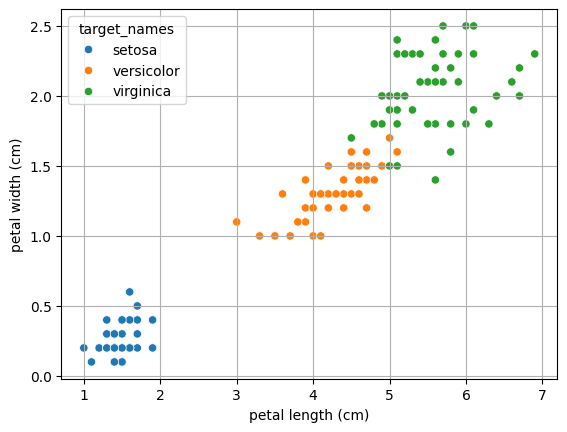

In [ ]:
df = pd.DataFrame(
    ds.data,
    columns=ds.feature_names,
)
df = pd.concat([df, pd.DataFrame([ds.target_names[t] for t in ds.target], columns=['target_names'])], axis=1)
seaborn.scatterplot(data=df, x='petal length (cm)', y='petal width (cm)', hue='target_names')
df.head()

# For experts...

You can also `from sklearn.linear_model import LogisticRegression` and apply it to our dataset.
It has way more parameters than our algorithm. Check especially, what the control parameter `C` does [1].
Can you spot at least the code [2], which performs the prediction?

- [1] http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html
- [2] https://github.com/scikit-learn/scikit-learn/blob/a24c8b46/sklearn/linear_model/logistic.py#L962

# Further reading
- Logistic regression for a related problem: http://ml-cheatsheet.readthedocs.io/en/latest/logistic_regression.html
- How are tied covariance matrices enforced? https://stats.stackexchange.com/questions/175477/how-is-the-tied-covariance-matrix-enforced-in-linear-discriminant-analysis
- Softmax regression tutorial: http://ufldl.stanford.edu/tutorial/supervised/SoftmaxRegression/